In [1]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

In [2]:
import sys

COLAB = 'google.colab' in str(get_ipython())
TRANSFORMS = True
HAS_GPU = torch.cuda.is_available()
is_local = not COLAB

if COLAB: # running on Colab
    
    from google.colab import drive
    drive.mount('/content/drive')
    gdrive_path = '/content/drive//MyDrive/DL4CV-2022/project-I/'
    sys.path.append(gdrive_path)

    zip_path_train = gdrive_path + 'data/Final_Training.zip'
    zip_path_val = gdrive_path + 'data/Final_Validation.zip'
    !unzip -q "{zip_path_train}"
    !unzip -q "{zip_path_val}"
    
    if HAS_GPU:
        print("Using GPU")
else:
    HAS_GPU = False
    print("Using CPU")
    
import utils.helpers as utils
import loader.gtsrb_data as dataset

# If we run cuda then accomodate these datatypes.
FloatTensor = torch.cuda.FloatTensor if HAS_GPU else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if HAS_GPU else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if HAS_GPU else torch.ByteTensor
Tensor = FloatTensor

Using CPU


In [3]:
if COLAB:
  !ls /content/Final_Training/Images
else:
    !ls data/Final_Training/Images

00000 00004 00008 00012 00016 00020 00024 00028 00032 00036 00040
00001 00005 00009 00013 00017 00021 00025 00029 00033 00037 00041
00002 00006 00010 00014 00018 00022 00026 00030 00034 00038 00042
00003 00007 00011 00015 00019 00023 00027 00031 00035 00039


In [4]:
import loader.args as load_args
args = load_args.get_args(is_local)

TRAIN_DATA_PATH = args.data_dir_train
VAL_DATA_PATH = args.data_dir_val
TEST_DATA_PATH = args.data_dir_test
BATCH_SIZE = args.batch_size
EPOCHS = 10
BATCH_SIZE = args.batch_size
LEARNING_RATE = args.learning_rate

In [5]:
from loader import transforms as tfs

if TRANSFORMS:

    train_loader = torch.utils.data.DataLoader(
          torch.utils.data.ConcatDataset([datasets.ImageFolder(
                                               TRAIN_DATA_PATH, 
                                               transform=tfs.data_transforms),
                                          datasets.ImageFolder(
                                               TRAIN_DATA_PATH,
                                               transform=tfs.data_translate),
                                          datasets.ImageFolder(
                                               TRAIN_DATA_PATH,
                                               transform=tfs.data_grayscale),
                                          datasets.ImageFolder(
                                               TRAIN_DATA_PATH,
                                               transform=tfs.data_center),
                                          datasets.ImageFolder(
                                               TRAIN_DATA_PATH,
                                               transform=tfs.data_rotate),
                                          datasets.ImageFolder(
                                               TRAIN_DATA_PATH,
                                               transform=tfs.data_jitter_hue)]), 
                                               batch_size=args.batch_size, 
                                               shuffle=True, num_workers=2, 
                                               pin_memory=HAS_GPU)

    val_loader = torch.utils.data.DataLoader(
          torch.utils.data.ConcatDataset([datasets.ImageFolder(
                                               VAL_DATA_PATH, 
                                               transform=tfs.data_transforms),
                                          datasets.ImageFolder(
                                               VAL_DATA_PATH,
                                               transform=tfs.data_translate),
                                          datasets.ImageFolder(
                                               VAL_DATA_PATH,
                                               transform=tfs.data_grayscale),
                                          datasets.ImageFolder(
                                               VAL_DATA_PATH,
                                               transform=tfs.data_center),
                                          datasets.ImageFolder(
                                               VAL_DATA_PATH,
                                               transform=tfs.data_rotate),
                                          datasets.ImageFolder(
                                               VAL_DATA_PATH,
                                               transform=tfs.data_jitter_hue)]), 
                                               batch_size=args.batch_size, 
                                               shuffle=False, num_workers=2, 
                                               pin_memory=HAS_GPU)
else:
  pass # without transforms the sample number is train=39209, test=12630, val=3870

In [6]:
print(len(train_loader)*50)
print(len(val_loader)*50)

235300
23250


Augmented dataset: 235254 training samples & 23220 validation samples

Distribution of classes in augmented train dataset:


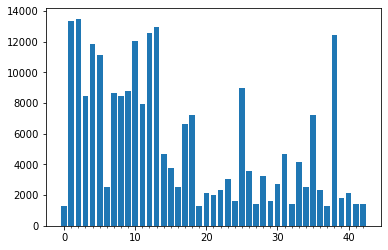

In [7]:
import matplotlib.pyplot as plt
print('Augmented dataset: %d training samples & %d validation samples\n' % (
    len(train_loader.dataset), len(val_loader.dataset)))

# Get labels from concatenated datasets.
train_dataset_list = train_loader.dataset.datasets
train_concat_labels = []
for ds in train_dataset_list:
    train_concat_labels.extend(ds.targets)
    
val_dataset_list = val_loader.dataset.datasets
val_concat_labels = []
for ds in val_dataset_list:
    val_concat_labels.extend(ds.targets)

class_labels = range(43)

print('Distribution of classes in augmented train dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(train_concat_labels, return_counts=True)
ax.bar(class_labels, counts)
ax.set_xticks(class_labels, minor=True)
plt.show()

In [8]:
# Neural Network and Optimizer
from model.models import Net as NN

model = NN()
if HAS_GPU:
    model.cuda()

# Optimizer is updated to *not* include non-gradient weights.    
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                                      lr=args.learning_rate)
# Reduce learning rate when a metric has stopped improving. 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                 patience=5,
                                                 factor=0.5,
                                                 verbose=True)

In [9]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]           1,184
         MaxPool2d-2            [-1, 8, 13, 13]               0
              ReLU-3            [-1, 8, 13, 13]               0
            Conv2d-4             [-1, 10, 9, 9]           2,010
         MaxPool2d-5             [-1, 10, 4, 4]               0
              ReLU-6             [-1, 10, 4, 4]               0
            Linear-7                   [-1, 32]           5,152
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10          [-1, 100, 28, 28]           7,600
      BatchNorm2d-11          [-1, 100, 14, 14]             200
        Dropout2d-12          [-1, 100, 14, 14]               0
           Conv2d-13          [-1, 150, 12, 12]         135,150
      BatchNorm2d-14            [-1, 15

In [10]:
def train(epoch):
    train_losses=[]
    train_accu=[]
    
    model.train()
    correct = 0
    training_loss = 0
    print('\nEpoch : %d'%epoch)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        if HAS_GPU:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        max_index = output.max(dim = 1)[1] # _, predicted
        correct += (max_index == target).sum()
        training_loss += loss
        
        if batch_idx % args.log_interval == 0:
            train_loss=training_loss / len(train_loader.dataset)
            accu = 100. * correct / len(train_loader.dataset)
            train_accu.append(accu)
            train_losses.append(train_loss)
            print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
            print('---------------------------------------------------')
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss per example: {:.6f}\tLoss: {:.6f}'.format(
                        epoch, 
                        batch_idx * len(data), # this batch number, times total length
                        len(train_loader.dataset), # length of the entire dataset.
                        100. * batch_idx / len(train_loader), 
                        loss.data.item()/(args.batch_size * args.log_interval),
                        loss.data.item()) )
            
            print('\nTraining set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                        training_loss / len(train_loader.dataset), 
                        correct, 
                        len(train_loader.dataset),
                        100. * correct / len(train_loader.dataset)))

            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss per example: {:.6f}\tLoss: {:.6f}'.format(
            #            epoch, batch_idx * len(data), len(train_loader.dataset),
            #            100. * batch_idx / len(train_loader), loss.data.item()/(args.batch_size * args.log_interval),
            #            loss.data.item()))
            #print('\nTraining set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            #    training_loss / len(train_loader.dataset), correct, len(train_loader.dataset),
            #    100. * correct / len(train_loader.dataset)))
    

In [ ]:
def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
            if HAS_GPU:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            validation_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    scheduler.step(np.around(validation_loss,2))
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    

In [ ]:
for epoch in range(1, args.num_epochs + 1):
    train(epoch)
    validation()

In [ ]:
'''
    train_data        = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, 
                                                         transform=tfs.data_transforms)
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
    test_data         = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, 
                                                         transform=tfs.data_transforms)
    test_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_data          = torchvision.datasets.ImageFolder(root=VAL_DATA_PATH, 
                                                         transform=tfs.data_transforms)
    val_loader   = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
    
    
ds = datasets.ImageFolder(VAL_DATA_PATH, transform=None)
#dir(ds)
#ds.samples[0:5] # the first five samples
#ds.imgs[33] # img 33
#ds.samples[33] # sample 33, equivalent of previous line
#ds.samples[33][0] # a sample path
#ds.samples[33][1] # a sample class label
#ds.find_classes(VAL_DATA_PATH)
#ds.targets

'''